# LOAD IN PACKAGES AND DATA

In [18]:
import pandas as pd
import numpy as np

In [26]:
df_results0 = pd.read_csv(r"../data/naacl-woah-results/full_test_run_cohere_naacl.csv", delimiter=",", on_bad_lines="skip")

In [27]:
df_results0.head()

,original_id,original_input,label,cohere_resp,language,task
0,0,Augusto Santos Silva perguntou na Convenção Eu...,Em publicação partilhada viralmente nas redes ...,75,pt,cohere-zero-shot-100-threshold
1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold
2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold
3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold
4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold


# PRE-PROCESSING?

In [28]:
#remove other and complicated labels 
df_results0 = df_results0[df_results0['label'].isin(['true', 'mostly true', 'partly true/misleading', 'complicated/hard to categorise', 'other', 'mostly false', 'false'])]
df_results0 = df_results0[pd.to_numeric(df_results0['cohere_resp'], errors='coerce').notnull()]
#TODO look at these values

In [29]:
df_results0.head()

,original_id,original_input,label,cohere_resp,language,task
1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold
2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold
3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold
4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold
5,6,مقطع فيديو يوثق اعتداء شبان على الشرطة المصرية...,partly true/misleading,20,ar,cohere-zero-shot-100-threshold


# PRELIMINARY LOOK AT THE DATA

In [30]:
df_results0.shape

(3546, 6)

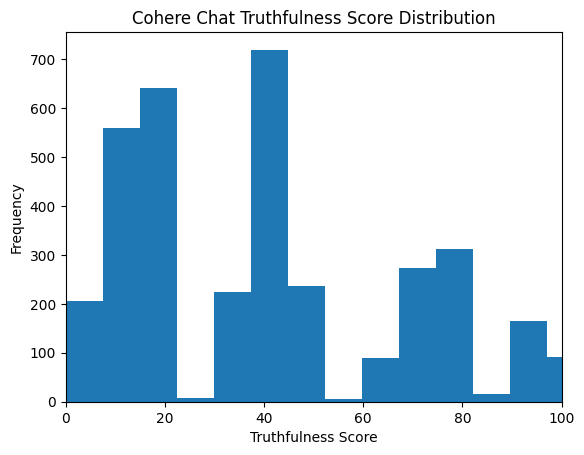

In [31]:
import matplotlib.pyplot as plt
plt.hist(df_results0['cohere_resp'].map(float).values,bins=50)
plt.xlim(0,100)
plt.title("Cohere Chat Truthfulness Score Distribution")
plt.xlim(0,100)
plt.ylabel("Frequency")
plt.xlabel("Truthfulness Score")
plt.show()

In [21]:
#function to get a rough idea of the distribution of different values in the dataset: looks like there are more false or questionable 
#than definitively true
def simplify_truth(row):
    if row['label'] in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 0
    else:
        return 1

df_results0['simple_truth'] = df_results0.apply(simplify_truth, axis=1)

df_results0["simple_truth"].value_counts() #much more false than true

simple_truth
0    2339
1    1310
Name: count, dtype: int64

# ACCURACY METRICS

In [32]:
#this function is a helper to calculate accuracy according to the x-fact and concrete papers
def cohere_tv(row):
    resp = row['cohere_resp']
    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp < 20: #TODO: tune this value?
        return "false"
    
    elif resp < 40:
        return "mostly false"
    
    elif resp < 60:
        return "partly true/misleading"
    
    elif resp < 80:
        return "mostly true"
    
    else:
        return "true"
    

df_results0['cohere_simple'] = df_results0.apply(cohere_tv, axis=1)
# print(df_results0.shape)
df_processed = df_results0.copy()#.drop(df_results0[(df_results0.cohere_simple != 0) & (df_results0.cohere_simple != 1)].index)
#df_processed = df_processed.drop(df_processed[df_processed.label.isin(['complicated/hard to categorise', 'other', np.nan])].index) #TODO: labels other than what's in the dict
df_processed = df_processed.reset_index()

In [33]:
df_processed.head()

,index,original_id,original_input,label,cohere_resp,language,task,cohere_simple
0,1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold,mostly true
1,2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold,false
2,3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold,partly true/misleading
3,4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold,partly true/misleading
4,5,6,مقطع فيديو يوثق اعتداء شبان على الشرطة المصرية...,partly true/misleading,20,ar,cohere-zero-shot-100-threshold,mostly false


In [12]:
from sklearn.metrics import classification_report
#TODO: use the 'naive' metric to present another measure of accuracy


### Overall Performance

In [34]:
def calculate_row_score(row): #according to concrete and x-fact code, available at https://github.com/khuangaf/CONCRETE/blob/master/src/xfact_eval.py
    score_mat = {

    'true':
            {
                'true':1.0,
                'mostly true':0.75,
                'partly true/misleading': 0.5,
                'complicated/hard to categorise': 0.0,
                'other': 0.0,
                'mostly false': 0.0,
                'false': 0.0
            },


    'mostly true':
            {
                'true':0.75,
                'mostly true':1.0,
                'partly true/misleading': 0.75,
                'complicated/hard to categorise': 0.0,
                'other': 0.0,
                'mostly false': 0.0,
                'false': 0.0
            },

    'partly true/misleading':
            {
                'true':0.25,
                'mostly true':0.50,
                'partly true/misleading': 1.0,
                'complicated/hard to categorise': 0.5,
                'other': 0.5,
                'mostly false': 0.50,
                'false': 0.25
            },



    'complicated/hard to categorise':
            {
                'true':0.0,
                'mostly true':0.0,
                'partly true/misleading': 0.0,
                'complicated/hard to categorise': 1.0,
                'other': 0.0,
                'mostly false': 0.0,
                'false': 0.0
            },


    'other':
            {
                'true':0.0,
                'mostly true':0.0,
                'partly true/misleading': 0,
                'complicated/hard to categorise': 0,
                'other': 1.0,
                'mostly false': 0.0,
                'false': 0.0
            },


    'mostly false':
            {
                'true':0.25,
                'mostly true':0.5,
                'partly true/misleading': 0.5,
                'complicated/hard to categorise': 0.5,
                'other': 0.5,
                'mostly false': 1.00,
                'false': 0.75
            },


    'false':
            {
                'true':0.0,
                'mostly true':0.25,
                'partly true/misleading': 0.5,
                'complicated/hard to categorise': 0.5,
                'other': 0.5,
                'mostly false': 0.75,
                'false': 1.0
            }


    }
    try:
        return score_mat[row["label"]][row["cohere_simple"]]
    except KeyError: #shouldn't happen - TODO do some testing
        return 0
    
df_processed['score'] = df_processed.apply(calculate_row_score, axis=1)  


In [35]:
df_processed.head()

,index,original_id,original_input,label,cohere_resp,language,task,cohere_simple,score
0,1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold,mostly true,0.25
1,2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold,false,1.00
2,3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold,partly true/misleading,0.50
3,4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold,partly true/misleading,1.00
4,5,6,مقطع فيديو يوثق اعتداء شبان على الشرطة المصرية...,partly true/misleading,20,ar,cohere-zero-shot-100-threshold,mostly false,0.50


In [36]:
print(df_processed["score"].sum() / len(df_processed["score"])) #note that concrete does this step inside the above function and produces a single score instead of a row-by-row score

0.5615482233502538


In [37]:
print(classification_report(df_processed['label'].values.tolist(), df_processed['cohere_simple'].values.tolist()))

                                precision    recall  f1-score   support

complicated/hard to categorise       0.00      0.00      0.00       100
                         false       0.53      0.30      0.39      1366
                  mostly false       0.06      0.39      0.11       143
                   mostly true       0.12      0.18      0.15       273
                         other       0.00      0.00      0.00        84
        partly true/misleading       0.25      0.29      0.27       808
                          true       0.36      0.27      0.31       772

                      accuracy                           0.27      3546
                     macro avg       0.19      0.20      0.17      3546
                  weighted avg       0.35      0.27      0.29      3546



c:\Users\annal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\annal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\annal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# PERFORMANCE DIFFERENCES ON DIFFERENT SUBSETS

In [15]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]: #german, spanish, french, italian, norwegian, dutch, polish
        return True
    else: #ar - arabic; az - azerbaijani; bn - bengali; fa - farsi; gu - gujarati; hi - hindi; id - indonesian
        #ka - georgian; mr - marathi; pa - punjabi; si - sinhala; ta - tamil; tr - turkish
        return False

In [18]:
def conservative_true(label):
    if label in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 0
    else:
        return 1

In [24]:
df_processed.shape

(3411, 9)

In [27]:
df_processed['label'][3410]

'true'

In [32]:
euro_y_true = []
euro_y_pred = []
non_euro_y_true = []
non_euro_y_pred = []
for i, rows in df_processed.iterrows():
    # print('hi')
    # print(i)
    # break
    # init_index = df_processed['index'][i]
    # if df_processed['label'][i]!=df_processed['label'][init_index]:
    #     pass
    #     # print(i, init_index)
    if euro_or_not(df_processed['language'][i]):
        euro_y_true.append(conservative_true(df_processed['label'][i]))
        euro_y_pred.append(df_processed['cohere_simple'][i])
    else:
        non_euro_y_true.append(conservative_true(df_processed['label'][i]))
        non_euro_y_pred.append(df_processed['cohere_simple'][i])

### Non-European vs European

In [33]:
print(classification_report(euro_y_true, euro_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1195
           1       0.54      0.44      0.48       757

    accuracy                           0.64      1952
   macro avg       0.61      0.60      0.60      1952
weighted avg       0.63      0.64      0.63      1952



In [34]:
print(classification_report(non_euro_y_true, non_euro_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1127
           1       0.36      0.33      0.34       332

    accuracy                           0.71      1459
   macro avg       0.58      0.58      0.58      1459
weighted avg       0.70      0.71      0.71      1459



### Western vs Non-Western

In [36]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return True
    else:
        return False

In [38]:
western_y_true = []
western_y_pred = []
non_western_y_true = []
non_western_y_pred = []
for i in range(df_processed.shape[0]):
    if western(df_processed['language'][i]):
        western_y_true.append(conservative_true(df_processed['label'][i]))
        western_y_pred.append(df_processed['cohere_simple'][i])
    else:
        non_western_y_true.append(conservative_true(df_processed['label'][i]))
        non_western_y_pred.append(df_processed['cohere_simple'][i])

In [39]:
print(classification_report(western_y_true, western_y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       915
           1       0.54      0.47      0.51       548

    accuracy                           0.65      1463
   macro avg       0.62      0.62      0.62      1463
weighted avg       0.65      0.65      0.65      1463



In [40]:
print(classification_report(non_western_y_true, non_western_y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1407
           1       0.41      0.33      0.37       541

    accuracy                           0.68      1948
   macro avg       0.59      0.57      0.58      1948
weighted avg       0.66      0.68      0.67      1948



### Small vs Large

In [41]:
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return True
    else: return False

In [43]:
small_y_true = []
small_y_pred = []
large_y_true = []
large_y_pred = []
for i in range(df_processed.shape[0]):
    if small(df_processed['language'][i]):
        small_y_true.append(conservative_true(df_processed['label'][i]))
        small_y_pred.append(df_processed['cohere_simple'][i])
    else:
        large_y_true.append(conservative_true(df_processed['label'][i]))
        large_y_pred.append(df_processed['cohere_simple'][i])

In [44]:
print(classification_report(small_y_true, small_y_pred))

              precision    recall  f1-score   support

           0       0.55      0.79      0.65       392
           1       0.55      0.28      0.37       356

    accuracy                           0.55       748
   macro avg       0.55      0.54      0.51       748
weighted avg       0.55      0.55      0.52       748



In [45]:
print(classification_report(large_y_true, large_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1930
           1       0.46      0.46      0.46       733

    accuracy                           0.70      2663
   macro avg       0.63      0.63      0.63      2663
weighted avg       0.70      0.70      0.70      2663



In [345]:
for i in df_processed['cohere_resp'].values:
    if float(i)<30:
        print(i)

15
25
8
25
19
22
10
16
16
10
20
16
15
25
0
10
15
25
16
15
16
20
8
8
12
15
10
16
16
25
22
10
10
8
25
25
22
12
0
15
16
12
0
15
25
28
25
15
23
16
25
0
0
8
8
12
12
15
16
12
25
15
15
15
16
10
10
15
10
0
15
23
25
0
15
15
23
12
25
15
16
15
25
12
12
16
16
15
25
10
12
15
16
16
12
25
15
25
8
8
12
12
28
15
15
15
10
12
12
15
0
12
15
12
10
8
16
16
25
22.5
15
12
8
15
10
25
25
25
25
15
10
16
16
15
8
0
25
25
15
8
22
15
12
10
15
10
16
25
25
15
25
10
15
10
10
16
1
25
15
25
0
25
16
8
15
25
12
13
12
15
10
25
10
25
25
0
16
15
25
16
25
15
25
16
15
23
10
25
22.3
22
15
15
15
25
10
25
22
25
25
15
12
25
10
10
23
16
10
20
12
12
15
25
15
12
25
8
